# Download Dataset

In [6]:
! kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder
! unzip -qq stanford-car-dataset-by-classes-folder.zip -d data
! rm -r stanford-car-dataset-by-classes-folder.zip

100% 1.82G/1.83G [00:16<00:00, 36.1MB/s]
100% 1.83G/1.83G [00:17<00:00, 114MB/s] 


In [5]:
!mv kaggle.json ../root/.kaggle/kaggle.json

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import matplotlib.image as mpimg
import os
import cv2
import copy
import pandas as pd

%matplotlib inline

plt.ion()   # interactive mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla T4


In [2]:
dataset_dir = "data/car_data/car_data/"

In [3]:
input_n = 224

data_transforms = {
    "train": transforms.Compose([transforms.Resize((input_n, input_n)),
                                 #transforms.Grayscale(num_output_channels=1),
                                 transforms.ToTensor(),
                                ]),
    "test": transforms.Compose([transforms.Resize((input_n, input_n)),
                                #transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                                ])
}


image_datasets = {x: datasets.ImageFolder(root=os.path.join(dataset_dir, x),
                                          transform=data_transforms[x])
                  for x in ['train', 'test']}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True if x == "train" else False, num_workers=6)
              for x in ['train', 'test']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Visualise Dataset

In [15]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(22,16))
    plt.imshow(inp)
    plt.axis('off')
    plt.pause(0.001)  # pause a bit so that plots are updated

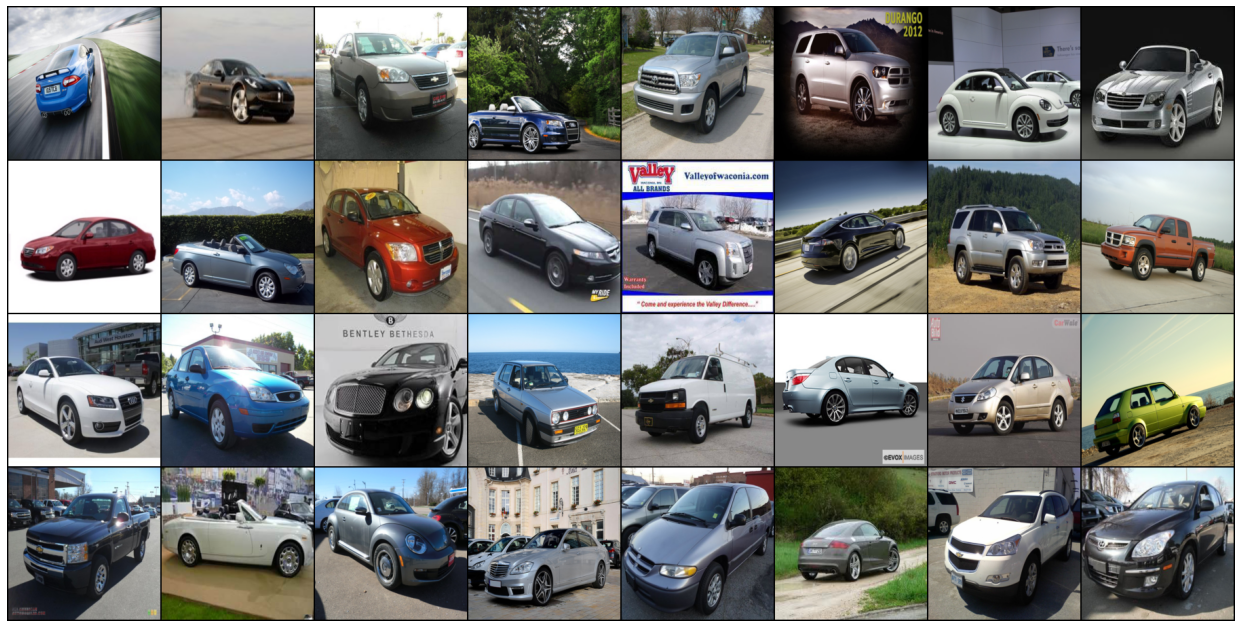

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Train and evalute model

In [4]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    losses = []
    accuracies = []
    test_accuracies = []
    test_losses = []
    
    model.to(device)
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        print(f'Epoch {epoch}/{n_epochs-1}')
        print('-' * 10)
        running_loss = 0.0
        running_correct = 0.0
        total = 0.0
        
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                losses.append(epoch_loss)
                accuracies.append(epoch_acc)
            else:
                test_losses.append(epoch_loss)
                test_accuracies.append(epoch_acc)
            print(f'{phase} Loss: {epoch_loss} Acc: {epoch_acc} => {epoch_acc * 100}%')
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print()
    
    return model, losses, accuracies, test_losses, test_accuracies

In [5]:
def visual(training_losses, training_accs, test_losses, test_accs, name):

    f, ax = plt.subplots(2,2, figsize = (12, 8))
    ax[0, 0].plot(training_losses)
    ax[0, 0].set_title("Training loss")
    ax[0, 1].plot(training_accs)
    ax[0, 1].set_title("Training acc")
    ax[1, 0].plot(test_losses)
    ax[1, 0].set_title("Test loss")
    ax[1, 1].plot(test_accs)
    ax[1, 1].set_title("Test acc")
    f.suptitle(f'Train visualise {name} 100\'s of batches')
    plt.show()

In [6]:
def training_model_with_visualize(models, names, learning_rate=0.001,
                                  n_epochs=4, saved=False):

    for i in range(len(models)):
        print(f'#### {names[i]}. Baseline ####')
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(models[i].parameters(), lr=learning_rate, momentum=0.9)
        lrscheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

        model_ft, training_losses, training_accs, test_losses, test_accs = train_model(models[i],
                                                criterion,
                                                optimizer,
                                                lrscheduler,
                                                n_epochs=n_epochs)

        visual(training_losses,
               training_accs,
               test_losses,
               test_accs,
               f'{names[i]} ({i+1} Conv2D)')

        #Save model
        if saved:
            model_dir = 'saved_models/'
            model_name = f'{names[i]}.pt'
            torch.save(model_ft.state_dict(), model_dir+model_name)
        del model_ft
        x = models[i]
        models[i] = 1
        del x
        torch.cuda.empty_cache()

# Define architecture Convolutional Neural Network

In [ ]:
class CNN_1_CP(nn.Module):
    def __init__(self, n_input, filters):
        super(CNN_1_CP, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 10, filters)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear((
            10 * (((n_input - filters + 1) // 2))**2 ), 200)
        
        self.fc2 = nn.Linear(200, 196)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
        
net1 = CNN_1_CP(input_n, 5)
print(net1)

CNN_1_CP(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=121000, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


In [ ]:
class CNN_2_CP(nn.Module):
    def __init__(self, n_input, filters):
        super(CNN_2_CP, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, filters)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(10, 20, filters)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(
            ((   ((n_input - filters + 1) // 2) 
                                - filters + 1)//2)**2 * 20 , 200)
        self.fc2 = nn.Linear(200, 196)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        
        return x
        
net2 = CNN_2_CP(input_n, 5)
print(net2)

CNN_2_CP(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=56180, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


In [ ]:
class CNN_3_CP(nn.Module):
    def __init__(self, n_input, filters):
        super(CNN_3_CP, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, filters)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(10, 20, filters)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(20, 30, filters)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(  30 * ((((   ((n_input - filters + 1) // 2) 
                                - filters + 1)//2) - filters + 1) // 2) ** 2 ,
                             200)
        self.fc2 = nn.Linear(200, 196)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        
        x = x.reshape(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
        
net3 = CNN_3_CP(input_n, 5)
print(net3)

CNN_3_CP(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=17280, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


In [ ]:
class CNN_4_CP(nn.Module):
    def __init__(self, n_input, filters):
        super(CNN_4_CP, self).__init__()
        self.conv1 = nn.Conv2d(3, 15, filters)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(15, 25, filters)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(25, 35, filters)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.Conv2d(35, 45, filters)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear( 45 * ((((((   ((n_input - filters + 1) // 2) 
                                - filters + 1)//2) - filters + 1) // 2)-filters + 1)//2 )**2 ,
                             200)
        self.fc2 = nn.Linear(200, 196)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        
        x = x.reshape(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
        
net4 = CNN_4_CP(input_n, 5)
print(net4)

CNN_4_CP(
  (conv1): Conv2d(3, 15, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(15, 25, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(25, 35, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(35, 45, kernel_size=(5, 5), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4500, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


#### CNN_1_CP. Baseline ####
Epoch 0/6
----------
train Loss: 5.280985266182112 Acc: 0.004658004412846285
test Loss: 5.275664876483848 Acc: 0.005220633934120571

Epoch 1/6
----------
train Loss: 5.266887317132821 Acc: 0.007477322873253247
test Loss: 5.257873477603872 Acc: 0.008203853325046613

Epoch 2/6
----------
train Loss: 5.224611023530915 Acc: 0.013851434175042901
test Loss: 5.209394501069083 Acc: 0.014418893722809198

Epoch 3/6
----------
train Loss: 5.155356013678429 Acc: 0.02108359892130424
test Loss: 5.195866866671869 Acc: 0.014170292106898694

Epoch 4/6
----------
train Loss: 5.131771374169621 Acc: 0.02537386614366266
test Loss: 5.186552276694308 Acc: 0.016407706650093227

Epoch 5/6
----------
train Loss: 5.110825120599049 Acc: 0.02782544741358176
test Loss: 5.1810894339628435 Acc: 0.016159105034182723

Epoch 6/6
----------
train Loss: 5.087830254189318 Acc: 0.03285118901691591
test Loss: 5.17849743998962 Acc: 0.016532007458048475



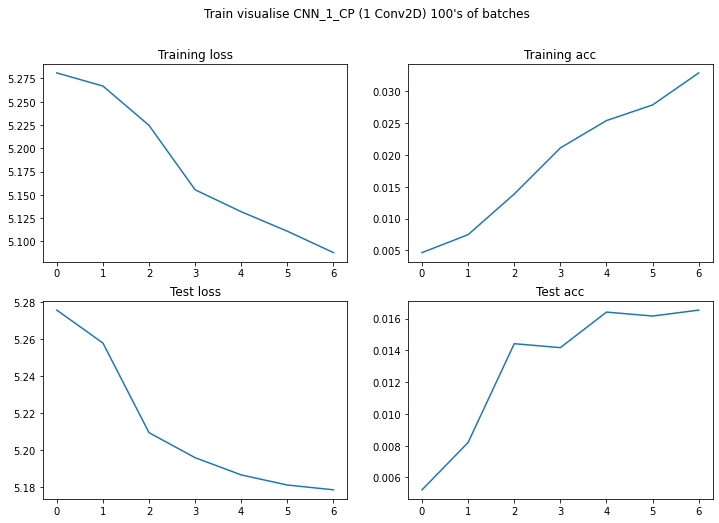

#### CNN_2_CP. Baseline ####
Epoch 0/6
----------
train Loss: 5.281354862090623 Acc: 0.005638636920813924
test Loss: 5.278312064195139 Acc: 0.005593536357986327

Epoch 1/6
----------
train Loss: 5.278422732539083 Acc: 0.00527089973032606
test Loss: 5.277590941671558 Acc: 0.008576755748912368

Epoch 2/6
----------
train Loss: 5.27716412185366 Acc: 0.008457955381220886
test Loss: 5.276428370952902 Acc: 0.008576755748912368

Epoch 3/6
----------
train Loss: 5.273992314821483 Acc: 0.008090218190733023
test Loss: 5.27609728065761 Acc: 0.00795525170913611

Epoch 4/6
----------
train Loss: 5.273315393799045 Acc: 0.008703113508212797
test Loss: 5.27574250296527 Acc: 0.007706650093225606

Epoch 5/6
----------
train Loss: 5.27253604221648 Acc: 0.008580534444716842
test Loss: 5.275348456473436 Acc: 0.008328154133001864

Epoch 6/6
----------
train Loss: 5.271648054995002 Acc: 0.008580534444716842
test Loss: 5.2753079448745 Acc: 0.008328154133001864



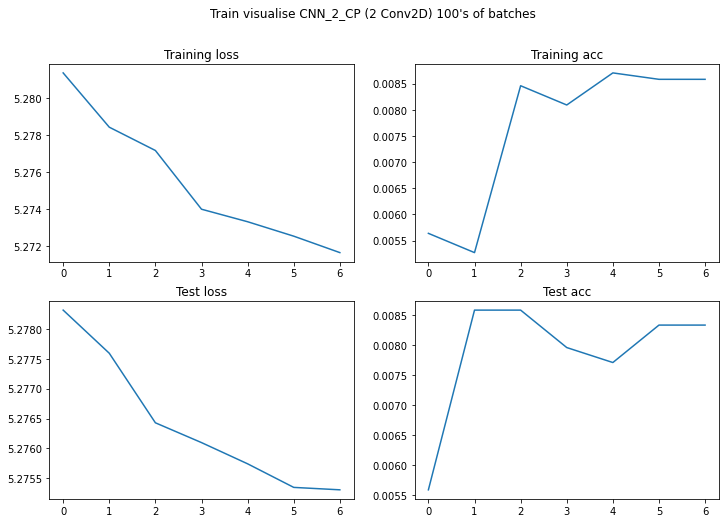

#### CNN_3_CP. Baseline ####
Epoch 0/6
----------
train Loss: 5.279033656914055 Acc: 0.004658004412846285
test Loss: 5.277835112524892 Acc: 0.008452454940957116

Epoch 1/6
----------
train Loss: 5.278059073890299 Acc: 0.008335376317724932
test Loss: 5.277210884734368 Acc: 0.008452454940957116

Epoch 2/6
----------
train Loss: 5.277373125109493 Acc: 0.008212797254228977
test Loss: 5.2764725955396505 Acc: 0.008452454940957116

Epoch 3/6
----------
train Loss: 5.275879238831935 Acc: 0.008335376317724932
test Loss: 5.276320488161001 Acc: 0.008452454940957116

Epoch 4/6
----------
train Loss: 5.27563699655423 Acc: 0.008335376317724932
test Loss: 5.276159381392285 Acc: 0.008452454940957116

Epoch 5/6
----------
train Loss: 5.275383938057336 Acc: 0.008335376317724932
test Loss: 5.275987974881681 Acc: 0.008452454940957116

Epoch 6/6
----------
train Loss: 5.275074689345606 Acc: 0.008335376317724932
test Loss: 5.27596964115975 Acc: 0.008452454940957116



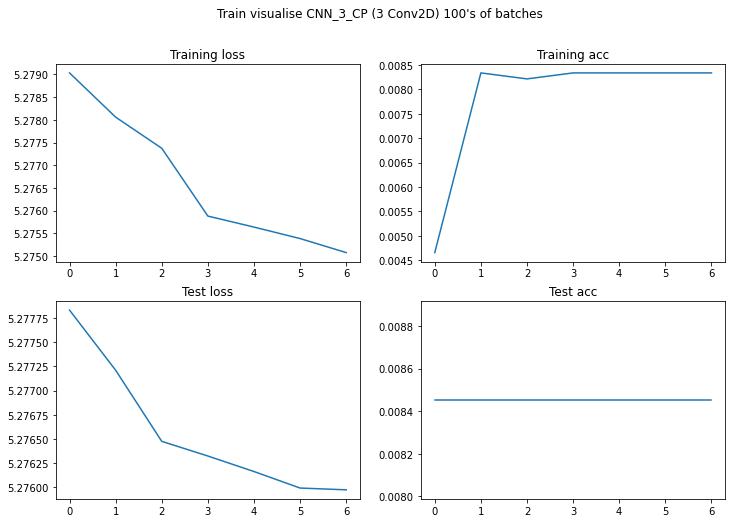

#### CNN_4_CP. Baseline ####
Epoch 0/6
----------
train Loss: 5.278497701650976 Acc: 0.00527089973032606
test Loss: 5.277996804300786 Acc: 0.00509633312616532

Epoch 1/6
----------
train Loss: 5.278191786941637 Acc: 0.00551605785731797
test Loss: 5.277754935127671 Acc: 0.005220633934120571

Epoch 2/6
----------
train Loss: 5.2779110935161615 Acc: 0.005393478793822014
test Loss: 5.277489908383158 Acc: 0.005966438781852082

Epoch 3/6
----------
train Loss: 5.2774892378215785 Acc: 0.0068644275557734735
test Loss: 5.277458260443138 Acc: 0.00584213797389683

Epoch 4/6
----------
train Loss: 5.277453201721333 Acc: 0.006006374111301789
test Loss: 5.2774266339000375 Acc: 0.006463642013673089

Epoch 5/6
----------
train Loss: 5.277416129415016 Acc: 0.006374111301789654
test Loss: 5.277394621856765 Acc: 0.006463642013673089

Epoch 6/6
----------
train Loss: 5.277366856319936 Acc: 0.005883795047805835
test Loss: 5.277391439761487 Acc: 0.006463642013673089



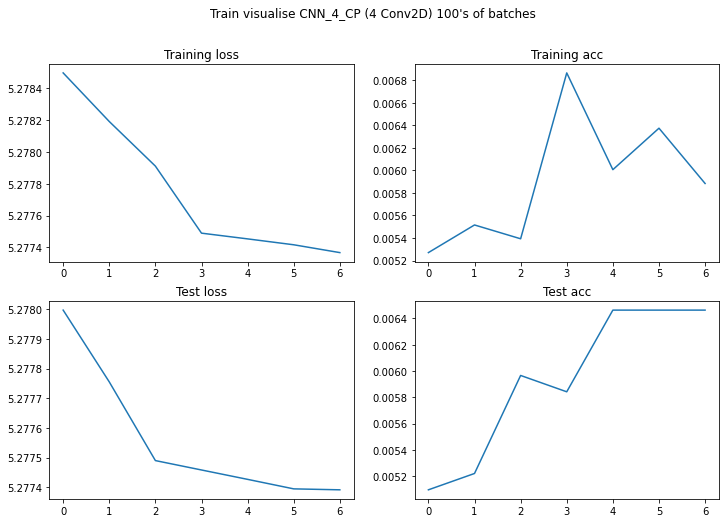

In [ ]:
models = [net1, net2, net3, net4]
names = [f"CNN_{i+1}_CP" for i in range(len(models))]

training_model_with_visualize(models, names, n_epochs=7)

# Apply dropouts

In [ ]:
class CNN_1_CPD(nn.Module):
    def __init__(self, n_input, filters):
        super(CNN_1_CPD, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 10, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.fc1 = nn.Linear((
            10 * (((n_input - filters + 1) // 2))**2 ), 200)
        self.fc2 = nn.Linear(200, 196)
        
    def forward(self, x):
        x = self.layer1(x)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
        
net11 = CNN_1_CPD(input_n, 5)
print(net11)

CNN_1_CPD(
  (layer1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout2d(p=0.35, inplace=False)
  )
  (fc1): Linear(in_features=121000, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


In [ ]:
class CNN_2_CPD(nn.Module):
    def __init__(self, n_input, filters):
        super(CNN_2_CPD, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 10, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(10, 20, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.fc1 = nn.Linear(
            ((   ((n_input - filters + 1) // 2) 
                                - filters + 1)//2)**2 * 20 , 200)
        self.fc2 = nn.Linear(200, 196)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
        
net22 = CNN_2_CPD(input_n, 5)
print(net22)

CNN_2_CPD(
  (layer1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout2d(p=0.35, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout2d(p=0.35, inplace=False)
  )
  (fc1): Linear(in_features=56180, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


In [ ]:
class CNN_3_CPD(nn.Module):
    def __init__(self, n_input, filters):
        super(CNN_3_CPD, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 10, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(10, 20, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(20, 30, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.fc1 = nn.Linear(  30 * ((((   ((n_input - filters + 1) // 2) 
                                - filters + 1)//2) - filters + 1) // 2) ** 2 ,
                             200)
        self.fc2 = nn.Linear(200, 196)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
        
net33 = CNN_3_CPD(input_n, 5)
print(net33)

CNN_3_CPD(
  (layer1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout2d(p=0.35, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout2d(p=0.35, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(20, 30, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout2d(p=0.35, inplace=False)
  )
  (fc1): Linear(in_features=17280, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


In [ ]:
class CNN_4_CPD(nn.Module):
    def __init__(self, n_input, filters):
        super(CNN_4_CPD, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 10, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(10, 20, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(20, 30, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(30, 40, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Dropout2d(.35)
        )
        
        self.fc1 = nn.Linear( 40 * ((((((   ((n_input - filters + 1) // 2) 
                                - filters + 1)//2) - filters + 1) // 2)-filters + 1)//2 )**2 ,
                             200)
        self.fc2 = nn.Linear(200, 196)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
        
net44 = CNN_4_CPD(input_n, 5)
print(net44)

CNN_4_CPD(
  (layer1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout2d(p=0.35, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout2d(p=0.35, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(20, 30, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout2d(p=0.35, inplace=False)
  )
  (layer4): Sequential(
    (0): Conv2d(30, 40, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout2d(p=0.35, inplace=False)
  )
  (fc1): Linear(in_features=4000, out_features=200, bias=True)
  (fc2): Li

#### CNN_1_CPD. Baseline ####
Epoch 0/6
----------
train Loss: 5.2779876738677105 Acc: 0.006374111301789654
test Loss: 5.26957106421348 Acc: 0.012802983219390926

Epoch 1/6
----------
train Loss: 5.258606923798423 Acc: 0.012135327286099533
test Loss: 5.243268947589464 Acc: 0.01230577998756992

Epoch 2/6
----------
train Loss: 5.21872857225441 Acc: 0.012380485413091443
test Loss: 5.200946198849295 Acc: 0.016904909881914232

Epoch 3/6
----------
train Loss: 5.171045775973466 Acc: 0.02206423142927188
test Loss: 5.185750132632448 Acc: 0.017153511497824736

Epoch 4/6
----------
train Loss: 5.155182779989689 Acc: 0.02132875704829615
test Loss: 5.178351674989709 Acc: 0.01740211311373524

Epoch 5/6
----------
train Loss: 5.14335390047923 Acc: 0.02132875704829615
test Loss: 5.172198281723791 Acc: 0.018645121193287754

Epoch 6/6
----------
train Loss: 5.1309958343618085 Acc: 0.02463839176268693
test Loss: 5.171046275156043 Acc: 0.018520820385332506



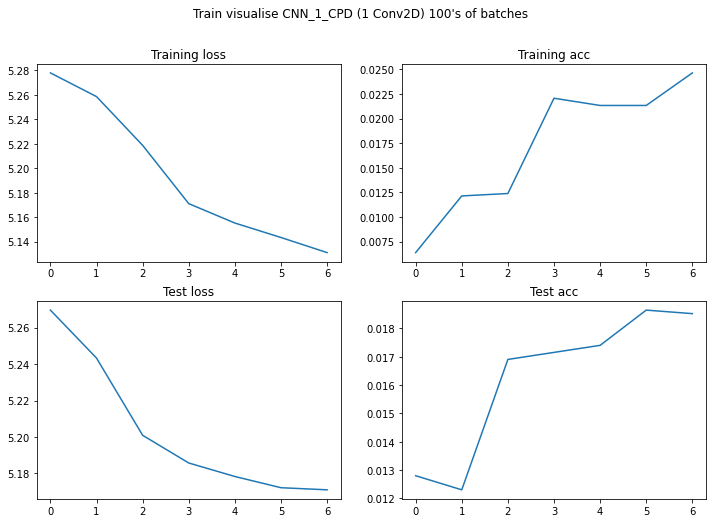

#### CNN_2_CPD. Baseline ####
Epoch 0/6
----------
train Loss: 5.280833310021814 Acc: 0.005638636920813924
test Loss: 5.2774487887798 Acc: 0.006215040397762586

Epoch 1/6
----------
train Loss: 5.277313552144755 Acc: 0.006374111301789654
test Loss: 5.276014449746065 Acc: 0.005966438781852082

Epoch 2/6
----------
train Loss: 5.274858760553179 Acc: 0.008090218190733023
test Loss: 5.272729151911288 Acc: 0.00944686140459913

Epoch 3/6
----------
train Loss: 5.270962849584506 Acc: 0.009561166952684481
test Loss: 5.272014926308205 Acc: 0.010689869484151647

Epoch 4/6
----------
train Loss: 5.270331070393317 Acc: 0.009070850698700662
test Loss: 5.271277543015181 Acc: 0.01093847110006215

Epoch 5/6
----------
train Loss: 5.268710834192686 Acc: 0.008457955381220886
test Loss: 5.270368218466389 Acc: 0.011559975139838408

Epoch 6/6
----------
train Loss: 5.267906616937591 Acc: 0.009561166952684481
test Loss: 5.270265392045044 Acc: 0.011808576755748913



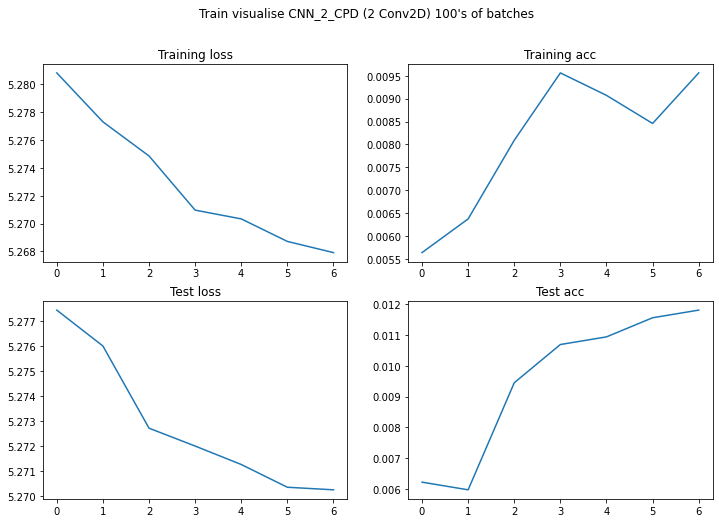

#### CNN_3_CPD. Baseline ####
Epoch 0/6
----------
train Loss: 5.278952054283028 Acc: 0.004903162539838195
test Loss: 5.278441738711891 Acc: 0.004723430702299565

Epoch 1/6
----------
train Loss: 5.278473425624592 Acc: 0.005393478793822014
test Loss: 5.278089040551147 Acc: 0.004723430702299565

Epoch 2/6
----------
train Loss: 5.278249681682731 Acc: 0.005393478793822014
test Loss: 5.277811871795938 Acc: 0.004723430702299565

Epoch 3/6
----------
train Loss: 5.277580035378694 Acc: 0.007477322873253247
test Loss: 5.277771245625687 Acc: 0.004723430702299565

Epoch 4/6
----------
train Loss: 5.277458321846534 Acc: 0.006006374111301789
test Loss: 5.277728303372304 Acc: 0.004723430702299565

Epoch 5/6
----------
train Loss: 5.2773865871378005 Acc: 0.005638636920813924
test Loss: 5.277682157804538 Acc: 0.004723430702299565

Epoch 6/6
----------
train Loss: 5.277325925011061 Acc: 0.007109585682765383
test Loss: 5.277678004964825 Acc: 0.004723430702299565



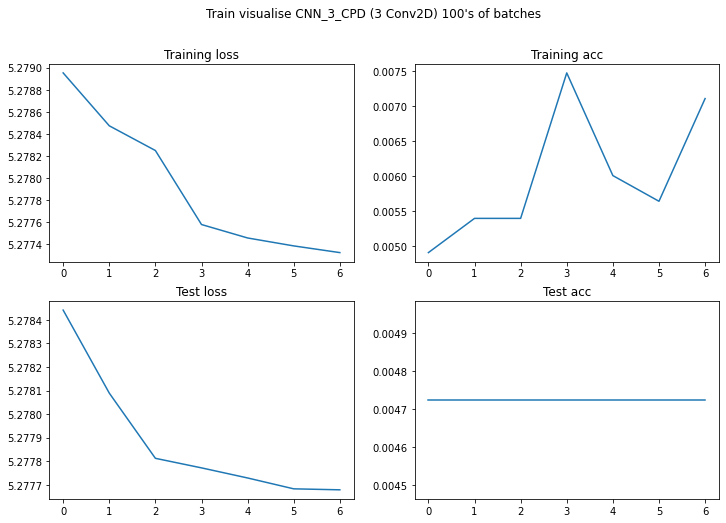

#### CNN_4_CPD. Baseline ####
Epoch 0/6
----------
train Loss: 5.2786858597933355 Acc: 0.00502574160333415
test Loss: 5.278506448803813 Acc: 0.004847731510254817

Epoch 1/6
----------
train Loss: 5.278565184103855 Acc: 0.004903162539838195
test Loss: 5.27825991528015 Acc: 0.004972032318210068

Epoch 2/6
----------
train Loss: 5.278305298734395 Acc: 0.00502574160333415
test Loss: 5.2780158395571615 Acc: 0.005469235550031075

Epoch 3/6
----------
train Loss: 5.277976174949576 Acc: 0.004658004412846285
test Loss: 5.277991631047336 Acc: 0.00584213797389683

Epoch 4/6
----------
train Loss: 5.277951352647134 Acc: 0.004290267222358421
test Loss: 5.277967683568069 Acc: 0.005717837165941578

Epoch 5/6
----------
train Loss: 5.27803309871508 Acc: 0.004535425349350331
test Loss: 5.277942283113526 Acc: 0.0074580484773151025

Epoch 6/6
----------
train Loss: 5.277780432770082 Acc: 0.00502574160333415
test Loss: 5.277939686440325 Acc: 0.007209446861404599



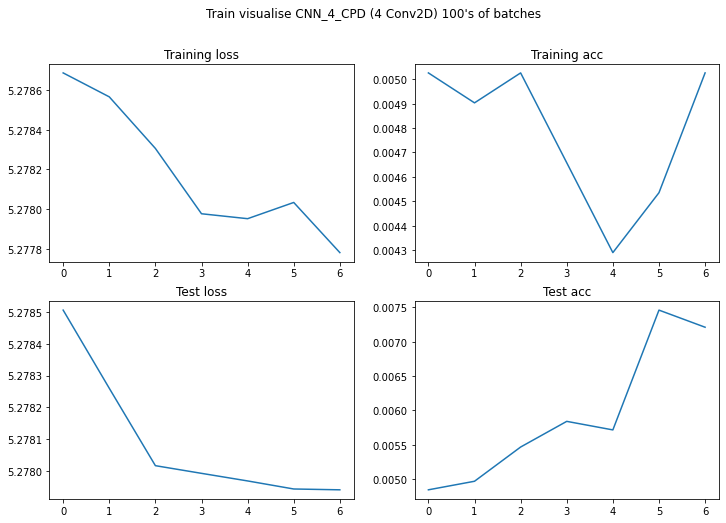

In [ ]:
models = [net11, net22, net33, net44]
names = [f"CNN_{i+1}_CPD" for i in range(len(models))]

training_model_with_visualize(models, names, n_epochs=7)

# Add batch normalization

In [8]:
class CNN_1_CPDB(nn.Module):
    def __init__(self, n_input, filters):
        super(CNN_1_CPDB, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 15, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(15),
            nn.Dropout2d(.5)
        )
        
        self.fc1 = nn.Linear((
            15 * (((n_input - filters + 1) // 2))**2 ), 600)
        self.b1 = nn.BatchNorm1d(600)
        self.d1 = nn.Dropout(.5)
        self.fc2 = nn.Linear(600, 196)
        
    def forward(self, x):
        x = self.layer1(x)
        x = x.reshape(x.size(0), -1)
        x = self.d1(self.b1(F.relu(self.fc1(x))))
        x = self.fc2(x)
        
        return x

        

print(CNN_1_CPDB(input_n, 5))

CNN_1_CPDB(
  (layer1): Sequential(
    (0): Conv2d(3, 15, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.5, inplace=False)
  )
  (fc1): Linear(in_features=181500, out_features=600, bias=True)
  (b1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (d1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=600, out_features=196, bias=True)
)


In [9]:
class CNN_2_CPDB(nn.Module):
    def __init__(self, n_input, filters):
        super(CNN_2_CPDB, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 15, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(15),
            nn.Dropout2d(.5)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(15, 35, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(35),
            nn.Dropout2d(.5)
        )
        
        self.fc1 = nn.Linear(
            ((   ((n_input - filters + 1) // 2) 
                                - filters + 1)//2)**2 * 35 , 600)
        self.b1 = nn.BatchNorm1d(600)
        self.d1 = nn.Dropout(.5)
        self.fc2 = nn.Linear(600, 196)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        
        x = x.reshape(x.size(0), -1)
        x = self.d1(self.b1(F.relu(self.fc1(x))))
        x = self.fc2(x)
        
        return x

        

print(CNN_2_CPDB(input_n, 5))

CNN_2_CPDB(
  (layer1): Sequential(
    (0): Conv2d(3, 15, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(15, 35, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(35, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.5, inplace=False)
  )
  (fc1): Linear(in_features=98315, out_features=600, bias=True)
  (b1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (d1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=600, out_features=196, bias=True)
)


In [10]:
class CNN_3_CPDB(nn.Module):
    def __init__(self, n_input, filters):
        super(CNN_3_CPDB, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 10, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout2d(.45)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(10, 20, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout2d(.45)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(20, 30, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(30),
            nn.Dropout2d(.45)
        )
        
        self.fc1 = nn.Linear(  30 * ((((   ((n_input - filters + 1) // 2) 
                                - filters + 1)//2) - filters + 1) // 2) ** 2 ,
                             600)
        self.b1 = nn.BatchNorm1d(600)
        self.d1 = nn.Dropout(.5)
        self.fc2 = nn.Linear(600, 196)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = x.reshape(x.size(0), -1)
        x = self.d1(self.b1(F.relu(self.fc1(x))))
        x = self.fc2(x)
        
        return x
        

print(CNN_3_CPDB(input_n, 5))

CNN_3_CPDB(
  (layer1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.45, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.45, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(20, 30, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.45, inplace=False)
  )
  (fc1): Linear(in_features=17280, 

In [11]:
class CNN_4_CPDB(nn.Module):
    def __init__(self, n_input, filters):
        super(CNN_4_CPDB, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 15, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(15),
            nn.Dropout2d(.2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(15, 25, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(25),
            nn.Dropout2d(.25)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(25, 35, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(35),
            nn.Dropout2d(.3)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(35, 45, filters),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(45),
            nn.Dropout2d(.35)
        )
        
        self.fc1 = nn.Linear( 45 * ((((((   ((n_input - filters + 1) // 2) 
                                - filters + 1)//2) - filters + 1) // 2)-filters + 1)//2 )**2 ,
                             600)
        self.b1 = nn.BatchNorm1d(600)
        self.d1 = nn.Dropout(.45)
        self.fc2 = nn.Linear(600, 196)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = x.reshape(x.size(0), -1)
        x = self.d1(self.b1(F.relu(self.fc1(x))))
        x = self.fc2(x)
        
        return x
        

print(CNN_4_CPDB(input_n, 5))

CNN_4_CPDB(
  (layer1): Sequential(
    (0): Conv2d(3, 15, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.2, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(15, 25, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.25, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(25, 35, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(35, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.3, inplace=False)
  )
  (layer4): Sequential(
    (0): Conv

#### CNN_1_CPDB. Baseline ####
Epoch 0/6
----------
train Loss: 5.470836083874955 Acc: 0.008718074656188604 => 0.8718074656188605%
test Loss: 5.152862839401695 Acc: 0.01952493470961323 => 1.952493470961323%
Training complete in 2m 48s

Epoch 1/6
----------
train Loss: 4.99391518501027 Acc: 0.05329076620825147 => 5.3290766208251465%
test Loss: 5.118259706510239 Acc: 0.021514736973013305 => 2.1514736973013306%
Training complete in 2m 52s

Epoch 2/6
----------
train Loss: 4.2140496887252 Acc: 0.18835952848722984 => 18.835952848722982%
test Loss: 5.153707834755421 Acc: 0.027608506404676034 => 2.7608506404676034%
Training complete in 2m 49s

Epoch 3/6
----------
train Loss: 2.744017902198147 Acc: 0.6388752455795678 => 63.88752455795677%
test Loss: 5.096553711522917 Acc: 0.03345355055341375 => 3.345355055341375%
Training complete in 2m 50s

Epoch 4/6
----------
train Loss: 2.544274544200635 Acc: 0.6925343811394892 => 69.25343811394892%
test Loss: 5.094480553249743 Acc: 0.0346971769680388 => 

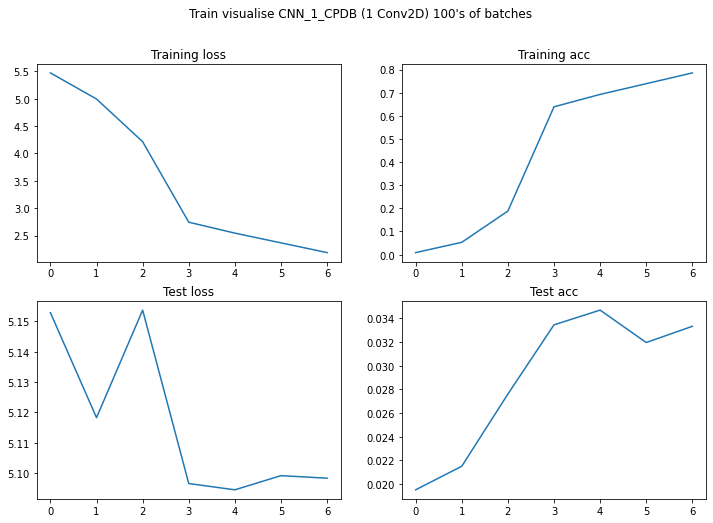

#### CNN_2_CPDB. Baseline ####
Epoch 0/6
----------
train Loss: 5.494232297646273 Acc: 0.01055992141453831 => 1.055992141453831%
test Loss: 5.168192736620097 Acc: 0.015794055465738092 => 1.5794055465738093%
Training complete in 3m 9s

Epoch 1/6
----------
train Loss: 5.113588324698577 Acc: 0.027504911591355596 => 2.7504911591355596%
test Loss: 5.093072248652657 Acc: 0.02611615470712598 => 2.611615470712598%
Training complete in 3m 7s

Epoch 2/6
----------
train Loss: 4.8148570960069215 Acc: 0.05783398821218074 => 5.783398821218074%
test Loss: 5.054220757723418 Acc: 0.03046884715831364 => 3.046884715831364%
Training complete in 3m 11s

Epoch 3/6
----------
train Loss: 4.415727690301382 Acc: 0.12524557956777996 => 12.524557956777995%
test Loss: 5.051052613098843 Acc: 0.03245864942171371 => 3.2458649421713712%
Training complete in 3m 5s

Epoch 4/6
----------
train Loss: 4.336666297350511 Acc: 0.14415520628683692 => 14.415520628683693%
test Loss: 5.0379948873986 Acc: 0.0348215396095013 => 

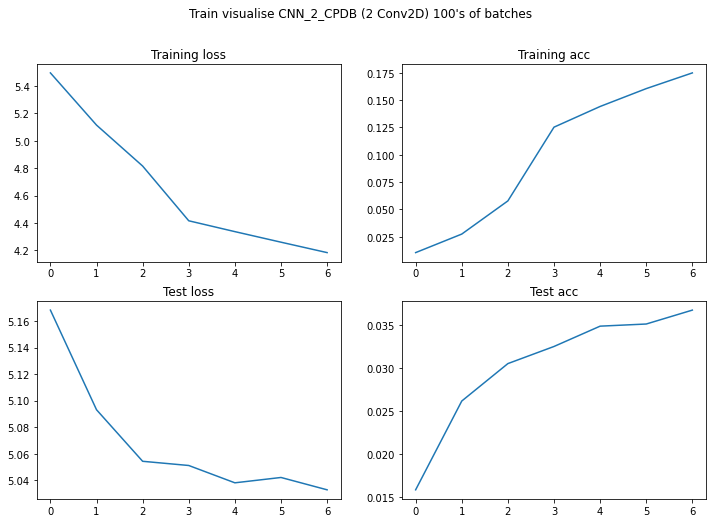

In [12]:
models = [CNN_1_CPDB(input_n, 5), CNN_2_CPDB(input_n, 5)]
names = [f"CNN_{i+1}_CPDB" for i in range(len(models))]

training_model_with_visualize(models, names, n_epochs=7)

#### CNN_3_CPDB. Baseline ####
Epoch 0/6
----------
train Loss: 5.51904704388092 Acc: 0.00724459724950884 => 0.724459724950884%
test Loss: 5.187386816969085 Acc: 0.014799154334038054 => 1.4799154334038054%
Training complete in 2m 27s

Epoch 1/6
----------
train Loss: 5.359197070415924 Acc: 0.011296660117878192 => 1.1296660117878192%
test Loss: 5.1182097828873 Acc: 0.017162044521825643 => 1.7162044521825643%
Training complete in 2m 27s

Epoch 2/6
----------
train Loss: 5.212391838343533 Acc: 0.019769155206286835 => 1.9769155206286835%
test Loss: 5.092150403409288 Acc: 0.019649297351075734 => 1.9649297351075734%
Training complete in 2m 27s

Epoch 3/6
----------
train Loss: 5.091539748291136 Acc: 0.02541748526522593 => 2.541748526522593%
test Loss: 5.075656157674933 Acc: 0.021514736973013305 => 2.1514736973013306%
Training complete in 2m 27s

Epoch 4/6
----------
train Loss: 5.086310007248974 Acc: 0.026522593320235755 => 2.6522593320235757%
test Loss: 5.069083707069613 Acc: 0.023753264519

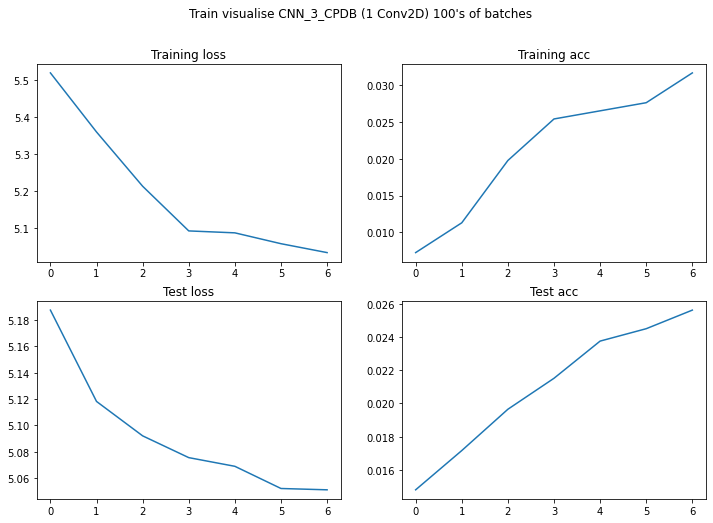

#### CNN_4_CPDB. Baseline ####
Epoch 0/6
----------
train Loss: 5.504994086057592 Acc: 0.006385068762278978 => 0.6385068762278978%
test Loss: 5.218046142396427 Acc: 0.0160427807486631 => 1.60427807486631%
Training complete in 3m 4s

Epoch 1/6
----------
train Loss: 5.253847224304859 Acc: 0.01461198428290766 => 1.461198428290766%
test Loss: 5.104486136750163 Acc: 0.024499440368113416 => 2.4499440368113414%
Training complete in 3m 5s

Epoch 2/6
----------
train Loss: 5.046746381373677 Acc: 0.029592337917485265 => 2.9592337917485265%
test Loss: 5.046917021207853 Acc: 0.02959830866807611 => 2.9598308668076108%
Training complete in 3m 2s

Epoch 3/6
----------
train Loss: 4.870129728598304 Acc: 0.04174852652259332 => 4.174852652259331%
test Loss: 5.0364201260716035 Acc: 0.03171247357293869 => 3.171247357293869%
Training complete in 3m 8s

Epoch 4/6
----------
train Loss: 4.831011552005011 Acc: 0.04923870333988212 => 4.923870333988212%
test Loss: 5.02392647957538 Acc: 0.03233428678025121 => 3

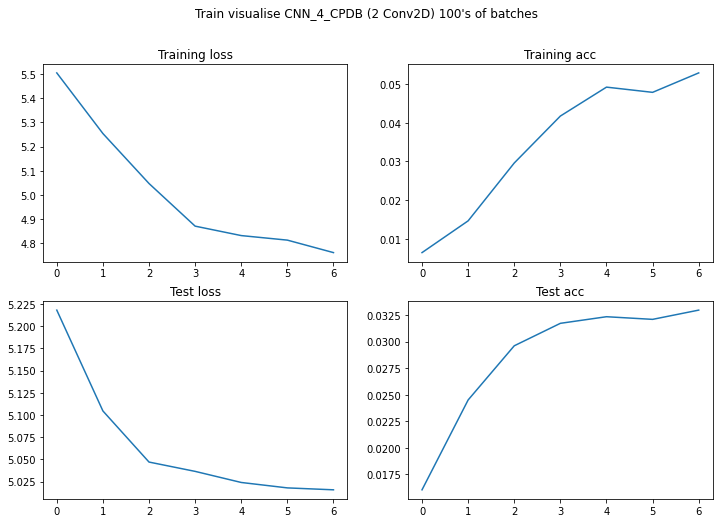

In [13]:
models = [CNN_3_CPDB(input_n, 5), CNN_4_CPDB(input_n, 5)]
names = [f"CNN_{i+3}_CPDB" for i in range(len(models))]

training_model_with_visualize(models, names, n_epochs=7)

# Added data augmentation

In [27]:
data_transforms = {
    "train": transforms.Compose([transforms.Resize((input_n, input_n)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(10),
                                 #torchvision.transforms.ColorJitter(brightness=0.2,
                                 #                                   contrast=0.5, saturation=0.2, hue=0.2),
                                 transforms.ToTensor(),
                                ]),
    "test": transforms.Compose([transforms.Resize((input_n, input_n)),
                                transforms.ToTensor(),
                                ])
}
    

image_datasets = {x: datasets.ImageFolder(root=os.path.join(dataset_dir, x),
                                          transform=data_transforms[x])
                  for x in ['train', 'test']}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True if x == "train" else False, num_workers=6)
              for x in ['train', 'test']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Visualize dataset

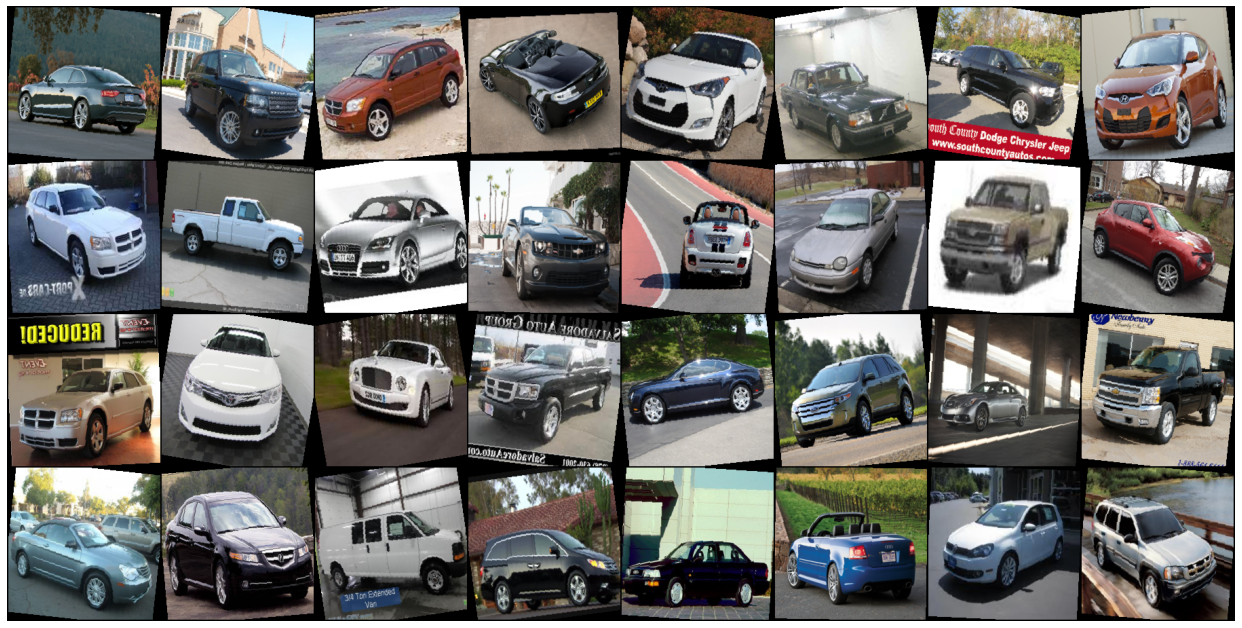

In [28]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#### CNN_4_CPDB_With_DataAugmentation. Baseline ####
Epoch 0/8
----------
train Loss: 5.467845228191443 Acc: 0.008472495088408643 => 0.8472495088408644%
test Loss: 5.170695862593957 Acc: 0.016415868673050615 => 1.6415868673050615%
Training complete in 2m 30s

Epoch 1/8
----------
train Loss: 5.240112786208717 Acc: 0.016822200392927308 => 1.6822200392927307%
test Loss: 5.087190154179636 Acc: 0.02213655018032583 => 2.2136550180325827%
Training complete in 2m 30s

Epoch 2/8
----------
train Loss: 5.127747945092282 Acc: 0.02210216110019646 => 2.2102161100196462%
test Loss: 5.037384054136282 Acc: 0.027111055838826014 => 2.7111055838826013%
Training complete in 2m 30s

Epoch 3/8
----------
train Loss: 5.020316656071452 Acc: 0.029837917485265222 => 2.983791748526522%
test Loss: 5.0165156276201435 Acc: 0.0320855614973262 => 3.20855614973262%
Training complete in 2m 30s

Epoch 4/8
----------
train Loss: 4.9942999523140355 Acc: 0.03352161100196464 => 3.3521611001964637%
test Loss: 4.998317420460

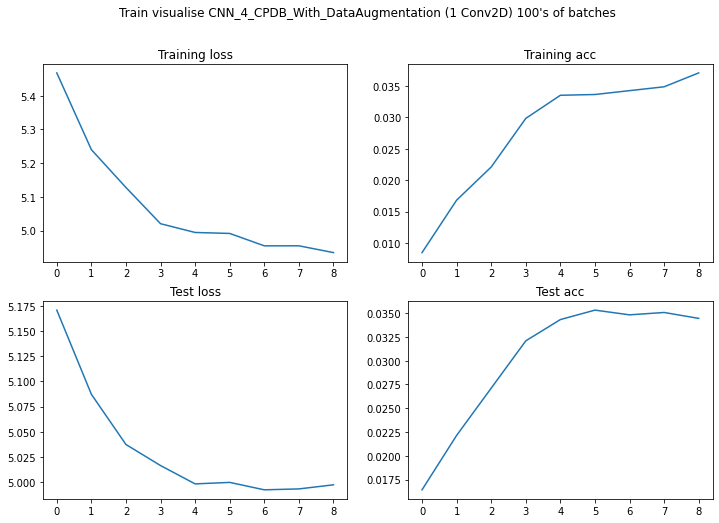

In [30]:
models = [CNN_4_CPDB(input_n, 5)]
names = [f"CNN_{i+4}_CPDB_With_DataAugmentation" for i in range(len(models))]

training_model_with_visualize(models, names, n_epochs=9)